In [11]:
import fitz
import matplotlib.pyplot as plt
import numpy as np

In [89]:
def find_threshold(doc):
    diffs = []
    for pageNo in range(10,doc.pageCount):
        page = doc[pageNo]
        words = page.getTextWords()
        
        for i in range(len(words)):
            piece = words[i]
            if i+1<len(words):
                next_piece = words[i+1]
            else:
                next_piece = None
            
            if next_piece != None:
                if next_piece[1]-piece[1] > 0.1 and next_piece[1]-piece[1]<page.bound()[3]/10: 
                    diffs.append(next_piece[1]-piece[1])
 
    plt.figure()
    n, bins, patches = plt.hist(diffs, bins=100, label="Difference", alpha=0.5, color="r")
    plt.legend(loc=1)
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.xticks(np.arange(10, 15, 0.25))
    plt.xlim(10, 15)
    plt.show()

In [20]:
def in_same_row(piece, next_piece):
    if next_piece[1] > piece[3] or next_piece[3] < piece[1]:
        return False
    else:
        return True

In [21]:
def paragraph_ending(piece, next_piece, threshold):
    if next_piece == None:
        return True
    if in_same_row(piece, next_piece):
        return False
    else:
        if abs(next_piece[1] - piece[1]) > threshold:
            return True
        else:
            return False

In [99]:
def create_txt(doc, threshold, start_page, end_page, exclude_pages):
    blocks = []
    block = ""
    min_y = doc[0].bound()[3]+1
    max_y = 0
    min_x = doc[0].bound()[2]+1
    max_x = 0
    for pageNo in range(start_page, end_page):
        if pageNo in exclude_pages:
            continue
        page = doc[pageNo]
        first = True
        nextSpace = True
        words = page.getTextWords()
        for i in range(len(words)):
            piece = words[i]
            if i+1<len(words):
                next_piece = words[i+1]
            else:
                next_piece = None
            word = piece[4]
            
            #update boundary
            min_y = min(min_y, piece[1])
            max_y = max(max_y, piece[3])
            
            min_x = min(min_x, piece[0])
            max_x = max(max_x, piece[2])
            
            if first and word==str(pageNo+1):
                first = False
                continue
            else:
                if next_piece==None:
                    block += word
                    blocks.append({"block":block, "pageNo":pageNo,"rectangle":(min_x, min_y, max_x, max_y)})
                    
                    block = ""
                    min_y = doc[0].bound()[3]+1
                    max_y = 0
                    min_x = doc[0].bound()[2]+1
                    max_x = 0
                else:
                    if paragraph_ending(piece, next_piece, threshold):
                        block += word
                        blocks.append({"block":block, "pageNo":pageNo,"rectangle":(min_x, min_y, max_x, max_y)})
                        
                        block = ""
                        min_y = doc[0].bound()[3]+1
                        max_y = 0
                        min_x = doc[0].bound()[2]+1
                        max_x = 0
                    else:
                        if word.endswith("-"):
                            block += word[:-1]
                        else:
                            block += word+" "
    return blocks

In [100]:
doc = fitz.open("Data/Cografya_12_2018-2019.pdf")

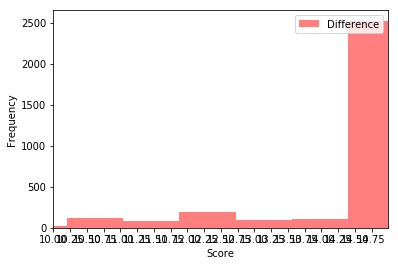

In [101]:
find_threshold(doc)

In [102]:
threshold = 18
start_page = 12
end_page = 210
exclude_pages = [26,27,28,45,46,70,71,88,89,110,111,126,127,145,146,166,167,191,192,193,194,195]

In [103]:
book = create_txt(doc, threshold, start_page, end_page, exclude_pages)

In [105]:
content = ""
for paragraph in sorted(book, key = lambda x: (x["pageNo"], x["rectangle"][1])):
    if len(paragraph["block"].split()) > 3:
        content += paragraph["block"]+"\n\n"

In [106]:
with open("Data/Cografya_12.txt", "w") as f:
    f.write(content)